In [6]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt 

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.epidemic import simulate_epidemic

## 1. Epidemic example from autoemulate

Easy simulation example as have only 2 input parameters and 1 output parameter

In [7]:
seed = 42
np.random.seed(seed)

beta = (0.1, 0.5) # lower and upper bounds for the transmission rate
gamma = (0.01, 0.2) # lower and upper bounds for the recovery rate
lhd = LatinHypercube([beta, gamma])
X = lhd.sample(200)
y = np.array([simulate_epidemic(x) for x in X])

print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")
print(f"X: {np.round(X[:3], 2)}\n")
print(f"y: {np.round(y[:3], 2)}\n")

shapes: input X: (200, 2), output y: (200,)

X: [[0.29 0.18]
 [0.13 0.04]
 [0.16 0.12]]

y: [0.09 0.31 0.03]



<function matplotlib.pyplot.show(close=None, block=None)>

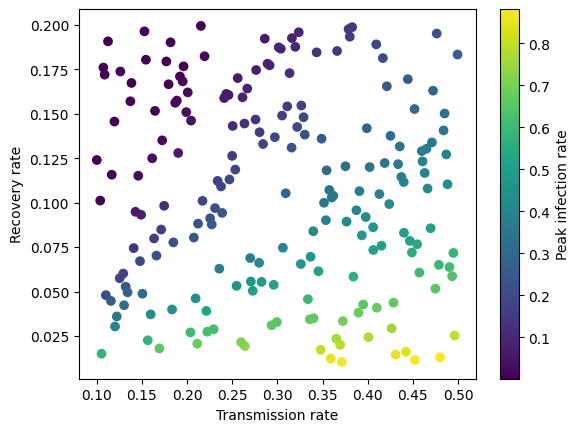

In [8]:
transmission_rate = X[:, 0]
recovery_rate = X[:, 1]

plt.scatter(transmission_rate, recovery_rate, c=y, cmap='viridis')
plt.xlabel('Transmission rate')
plt.ylabel('Recovery rate')
plt.colorbar(label="Peak infection rate")
plt.show

## 2. Train GP with torch

We fit a GP emulator to the simulated data for use in downstream tasks.

In [9]:
class GPEmulator(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPEmulator, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Constant mean
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())  # RBF kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

In [21]:
# Set up the model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPEmulator(X_train, y_train, likelihood)

# Training mode
model.train()
likelihood.train()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss function: Marginal Log Likelihood (MLL)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
num_epochs = 100
for i in range(num_epochs):
    optimizer.zero_grad()  # Reset gradients
    output = model(X_train)  # Get GP predictions
    loss = -mll(output, y_train)  # Negative log likelihood loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update hyperparameters
    
    if i % 10 == 0:
        print(f"Epoch {i+1}/{num_epochs} - Loss: {loss.item():.4f}")

Epoch 1/100 - Loss: 0.7727
Epoch 11/100 - Loss: 0.3823
Epoch 21/100 - Loss: -0.0641
Epoch 31/100 - Loss: -0.5388
Epoch 41/100 - Loss: -1.0190
Epoch 51/100 - Loss: -1.4828
Epoch 61/100 - Loss: -1.9114
Epoch 71/100 - Loss: -2.2962
Epoch 81/100 - Loss: -2.6034
Epoch 91/100 - Loss: -2.8169


Once we have an emulator, we can use it for predictions in place of the simulator.

In [29]:
# Switch model to evaluation mode
model.eval()
likelihood.eval()

# Get predictions with uncertainty
with torch.no_grad():
    # just use the first train example - index to preserve dimension
    pred_dist = model(X_train[:1])
    pred_mean = pred_dist.mean
    pred_std = pred_dist.stddev
    
pred_mean, pred_dist

(tensor([0.0883]), MultivariateNormal(loc: tensor([0.0883])))

## 3. MLE calibration

Now that we can have an emulator, there are other things we might want to do with it. For example, once we observe some real world data we might want to find the simulator parameters that best capture the data (i.e., maximize likehood).

In [31]:
def negative_log_likelihood(model_params, obs):
     model_mean, model_var = model_params
     obs_mean, obs_var = obs
     
     total_var = model_var + obs_var
     log_likelihood = 0.5 * torch.log(2 * torch.pi * total_var) + (
         obs_mean - model_mean
     ) ** 2 / (2 * total_var)
     return log_likelihood.sum()  # Sum over all observations

In [41]:
def calibrate_model(gp_model, obs, param_init, lr=0.01, epochs=1000):
    """
    Optimize the true simulator parameters using MLE.
    """
    
    obs_mean = torch.tensor(obs[0], dtype=torch.float32)
    obs_var = torch.tensor(obs[1], dtype=torch.float32)

    params = torch.tensor(param_init, dtype=torch.float32, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr)

    for i in range(epochs):
        optimizer.zero_grad()
        
        preds = gp_model(params)
        model_mean = preds.mean
        model_var = preds.variance + 1e-6  # Add small value for numerical stability
        
        nll = negative_log_likelihood((model_mean, model_var), (obs_mean, obs_var))
        nll.backward()
        optimizer.step()

        if i % 20 == 0:
            print(f"Epoch {i+1}/{epochs}, NLL: {nll.item()}, Params: {params.detach().numpy()}")

    return params.detach().numpy()    

In [60]:
# generate observation using some "true" parameter values
y = model(torch.tensor([[0.25, 0.19]]))
# the second value is some observation noise
obs = [y.mean, y.variance]

# pick some initial parameter values for the optimizer
params_init = [[0.5, 0.3]]

The below should recover something close to the true parameters

In [61]:
calibrate_model(model, obs, params_init)

/var/folders/bj/kdwy1bhj3h728lr5xdj19yd40000gr/T/ipykernel_13539/368885032.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_mean = torch.tensor(obs[0], dtype=torch.float32)
/var/folders/bj/kdwy1bhj3h728lr5xdj19yd40000gr/T/ipykernel_13539/368885032.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_var = torch.tensor(obs[1], dtype=torch.float32)


Epoch 1/1000, NLL: -0.3545547127723694, Params: [[0.49       0.29000002]]
Epoch 21/1000, NLL: -0.9810461401939392, Params: [[0.33569813 0.25437015]]
Epoch 41/1000, NLL: -4.122969150543213, Params: [[0.2114292  0.16588397]]
Epoch 61/1000, NLL: -4.139532566070557, Params: [[0.20275843 0.15829706]]
Epoch 81/1000, NLL: -4.158206939697266, Params: [[0.20164779 0.15701056]]
Epoch 101/1000, NLL: -4.153889179229736, Params: [[0.20146179 0.15717809]]
Epoch 121/1000, NLL: -4.162630558013916, Params: [[0.20178944 0.15712024]]
Epoch 141/1000, NLL: -4.157536506652832, Params: [[0.20200898 0.15720233]]
Epoch 161/1000, NLL: -4.157967567443848, Params: [[0.20179123 0.15765023]]
Epoch 181/1000, NLL: -4.1632819175720215, Params: [[0.20194481 0.15762547]]
Epoch 201/1000, NLL: -4.15928316116333, Params: [[0.2022446  0.15747571]]
Epoch 221/1000, NLL: -4.156802654266357, Params: [[0.20224063 0.15764256]]
Epoch 241/1000, NLL: -4.154951572418213, Params: [[0.20219974 0.15776692]]
Epoch 261/1000, NLL: -4.16386

array([[0.20203905, 0.15802275]], dtype=float32)